In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline
import lightgbm as lg

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#read in aggregate dataset from all data collection sources
mlb = pd.read_csv('data/mlb_final_pre_eda.csv', low_memory = False, index_col = [0])

In [3]:
pd.set_option('max.columns', 100)
mlb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200109 entries, 0 to 2423
Data columns (total 67 columns):
date                    200109 non-null object
season                  200109 non-null int64
neutral                 200109 non-null int64
playoff                 1617 non-null object
team1                   200109 non-null object
team2                   200109 non-null object
elo1_pre                200109 non-null float64
elo2_pre                200109 non-null float64
elo_prob1               200109 non-null float64
elo_prob2               200109 non-null float64
elo1_post               200109 non-null float64
elo2_post               200109 non-null float64
rating1_pre             200109 non-null float64
rating2_pre             200109 non-null float64
pitcher1                200099 non-null object
pitcher2                200099 non-null object
pitcher1_rgs            185848 non-null float64
pitcher2_rgs            185848 non-null float64
pitcher1_adj            185167 non-null

In [4]:
mlb['date'] = pd.to_datetime(mlb['date'], format = '%Y-%m-%d')
mlb = mlb.sort_values(by = ['date'], axis = 0)
mlb = mlb.reset_index().drop(columns = ['index'])
mlb.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,rating1_pre,rating2_pre,pitcher1,pitcher2,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2,team_code,team,state_code,year,primary_stadium,primary_latitude,primary_longitude,secondary_stadium,secondary_latitude,secondary_longitude,attendance/game,pitching_park_factor,batting_park_factor,station_id,TMAX,TMIN,PRCP,SNOW,SNWD,ACSH,WSFG,WSFI,WSFM,WSF1,AWND,PSUN,WSF2,WSF5,latitude,longitude,ACSC,is_double_header,is_triple_header,team_name,rg_code,away_team,home_team,game_time,park_id_x,attendance,park_id_y
0,1900-04-19,1900,0,NaN,STL,PIT,1503.240,1516.607,0.515297,0.484703,1505.258,1514.589,1503.335,1516.682,leevs101,younc102,NaN,NaN,NaN,NaN,0.516129,0.483871,1505.333,1514.684,3,0,STL,St. Louis Cardinals,MO,1900.0,Robison Field,38.662778,90.222222,NaN,NaN,NaN,"3,750",98.0,98.0,USW00093963,211.0,94.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.662778,90.222222,NaN,0,0,St. Louis Cardinals,SLN,PIT,SLN,NaN,STL05,12000.0,STL05
1,1900-04-19,1900,0,NaN,ATL,PHI,1550.730,1536.910,0.554213,0.445787,1548.944,1538.697,1550.654,1536.878,ortha101,willv101,NaN,NaN,NaN,NaN,0.554151,0.445849,1548.856,1538.675,17,19,ATL,Boston Beaneaters,MA,1900.0,South End Grounds III,42.337500,71.086944,NaN,NaN,NaN,"2,767",111.0,111.0,USW00094701,233.0,111.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.337500,71.086944,NaN,0,0,Boston Beaneaters,BSN,PHI,BSN,NaN,BOS05,10000.0,BOS05
2,1900-04-19,1900,0,NaN,SFG,LAD,1476.101,1541.571,0.440602,0.559398,1474.940,1542.732,1476.107,1541.625,kennb101,carrb102,NaN,NaN,NaN,NaN,0.443621,0.556379,1474.944,1542.788,2,3,SFG,New York Giants,NY,1900.0,Polo Grounds IV,40.798056,73.950278,NaN,NaN,NaN,"2,676",97.0,95.0,USC00305540,122.0,56.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.798056,73.950278,NaN,0,0,New York Giants,NY1,BRO,NY1,NaN,NYC10,15000.0,NYC10
3,1900-04-19,1900,0,NaN,CIN,CHC,1519.974,1507.474,0.552335,0.447665,1517.588,1509.859,1519.960,1507.347,grifc101,philb101,NaN,NaN,NaN,NaN,0.555300,0.444700,1517.559,1509.748,10,13,CIN,Cincinnati Reds,OH,1900.0,League Park II,41.511389,81.644167,NaN,NaN,NaN,"2,698",99.0,97.0,USC00331662,178.0,89.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.511389,81.644167,NaN,0,0,Cincinnati Reds,CIN,CHN,CIN,NaN,CIN05,12000.0,CIN05
4,1900-04-20,1900,0,NaN,SFG,LAD,1474.940,1542.732,0.437310,0.562690,1477.816,1539.856,1474.944,1542.788,kitsf101,seymc101,NaN,NaN,NaN,NaN,0.437236,0.562764,1477.820,1539.912,12,8,SFG,New York Giants,NY,1900.0,Polo Grounds IV,40.798056,73.950278,NaN,NaN,NaN,"2,676",97.0,95.0,USC00305540,139.0,83.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.798056,73.950278,NaN,0,0,New York Giants,NY1,BRO,NY1,NaN,NYC10,NaN,NYC10


Modeling professional sporting outcomes is an extremely complex undertaking as there are so many potential features and an inherently limited dataset: there are only so many games to collect. While feature selection is an important part of modeling and too many features can pose a large problem, it is always better to start with too many features and narrow the field than to potentially miss an important predictive feature. 

I felt several things were unaccounted for in the current data: momentum, distance traveled, length of time on the road, and road/home splits. To account for this, I created an object, __TeamFeatureEngineer__ (available in the feature_creator.py file in the repo) that tracks team performance and team travel throughout each individual season to try to capture the effect of momentum and travel on teams. In total, the __TeamFeatureEngineer__ created 13 features, which I outline below:

- len_homestand: Number of consecutive games the home team has played at home.
- current_streak_hm_tm: Number of consecutive wins or losses for the home team. Resets to 0 with a tie.
- current_streak_hm_at_hm: Number of consecutive wins or losses for home team while at home. Resets to 0 with a tie.
- home_record_hm: Overall home record (number of games above or below .500, a value of 0 represents .500 at home)
- run_differential_hm: Total run differential of home team playing at home
- avg_margin_hm: Average margin of victory or defeat of home team while playing at home 
- distance_traveled: Distance traveled by road team on current road trip. Resets to 0 each time road team returns home. Calculated using Haversine Distance with stadiums Latitude and Longitude (see feature_collector.py)
- len_roadtrip: Number of consecutive games played by road team on the road.
- current_streak_rd_tm: Number of consecutive wins or losses for the road team. Resets to 0 with a tie.
- current_streak_rd_tm_on_rd: Number of consecutive wins or losses for the road team on the road. Resets to 0 with a tie.
- rd_record_rd: Road teams current road record (number of games above or below .500)
- run_differential_rd: Total run differential of road team playing on road.
- avg_margin_rd: Average margin of victory or defeat of road team playing on road. 

In [5]:
#create new features
mlb = mlb.assign(len_homestand = 0)
mlb = mlb.assign(current_streak_hm_tm = 0)
mlb = mlb.assign(current_streak_hm_at_hm = 0)
mlb = mlb.assign(home_record_hm = 0)
mlb = mlb.assign(run_differential_hm = 0)
mlb = mlb.assign(avg_margin_hm = 0)

mlb = mlb.assign(distance_traveled = 0)

mlb = mlb.assign(len_roadtrip = 0)
mlb = mlb.assign(current_streak_rd_tm = 0)
mlb = mlb.assign(current_streak_rd_tm_on_rd = 0)
mlb = mlb.assign(rd_record_rd = 0)
mlb = mlb.assign(run_differential_rd = 0)
mlb = mlb.assign(avg_margin_rd = 0)

In [6]:
#import user defined classes
from feature_creator import Team, TeamFeatureEngineer

In [7]:
#update DataFrame
mlb_update = TeamFeatureEngineer()
mlb_update.create_features(mlb)

In [8]:
mlb = mlb_update.create_frame()

In [9]:
mlb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200109 entries, 0 to 200108
Data columns (total 80 columns):
date                          200109 non-null datetime64[ns]
season                        200109 non-null int64
neutral                       200109 non-null int64
playoff                       1617 non-null object
team1                         200109 non-null object
team2                         200109 non-null object
elo1_pre                      200109 non-null float64
elo2_pre                      200109 non-null float64
elo_prob1                     200109 non-null float64
elo_prob2                     200109 non-null float64
elo1_post                     200109 non-null float64
elo2_post                     200109 non-null float64
rating1_pre                   200109 non-null float64
rating2_pre                   200109 non-null float64
pitcher1                      200099 non-null object
pitcher2                      200099 non-null object
pitcher1_rgs                 

In [10]:
#observe summary statistics for newly created features
new_features = mlb[mlb.columns[66:80]]
new_features.describe()

,len_homestand,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,distance_traveled,len_roadtrip,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd
count,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000,200109.000000
mean,20.709848,0.065144,0.344667,3.299052,6.519537,0.085788,811.219875,20.531141,-0.507958,-0.333238,-3.022803,-5.353692,-0.088722
std,25.465133,2.434648,2.602654,9.054252,40.221514,0.997454,1275.411159,25.378911,2.199598,2.590980,9.040470,40.407269,1.005911
min,1.000000,-20.000000,-20.000000,-43.000000,-215.000000,-16.000000,0.000000,1.000000,-23.000000,-22.000000,-52.000000,-218.000000,-18.000000
25%,1.000000,-1.000000,-1.000000,-2.000000,-14.000000,0.000000,0.000000,1.000000,-2.000000,-2.000000,-8.000000,-25.000000,0.000000
50%,3.000000,1.000000,1.000000,2.000000,4.000000,0.000000,123.000000,3.000000,-1.000000,-1.000000,-2.000000,-3.000000,0.000000
75%,40.000000,2.000000,2.000000,8.000000,27.000000,0.000000,1151.000000,40.000000,1.000000,1.000000,2.000000,15.000000,0.000000
max,91.000000,18.000000,24.000000,50.000000,229.000000,18.000000,24729.000000,90.000000,19.000000,17.000000,46.000000,294.000000,16.000000


In [11]:
#there is a problem with homestand and roadtrip features, dropped features
mlb = mlb.drop(columns = ['len_homestand', 'len_roadtrip'])
new_features = new_features.drop(columns = ['len_homestand', 'len_roadtrip'])

An additional feature to account for with all of the data that has been collected is in regards to the stadium types themselves: Is the stadium a fixed roof stadium, thus rendering the weather observations useless? Is the stadium a retractable roof stadium, and if so, was the roof closed? I added two dummy variables to account for whether or not the the stadium is a fixed roof stadium or a retractable roof stadium. Once I have dealt with missing values/outliers from the weather observations columns, I will update these stadiums to reflect the games being played indoors.

In [12]:
#add features to indicate whether roof was closed or not
mlb = mlb.assign(roof_closed = 0)
mlb = mlb.assign(is_retractable = 0)

In [13]:
#generate list of indices of fixed roof stadiums
fixed_indices = mlb[(mlb.primary_stadium == 'Tropicana Field') | (mlb.primary_stadium == 'Astrodome') |
                   (mlb.primary_stadium == 'Stade Olympique') | 
                    (mlb.primary_stadium == 'Hubert H. Humphrey Metrodome') |
                   (mlb.primary_stadium == 'Kingdome')].index

In [14]:
#update dummy variable at indices of fixed roof stadiums 
for index in fixed_indices:
    mlb.at[index, 'roof_closed'] = 1

In [15]:
#generate list of indices for retractable roof stadiums 
retractable_indices = mlb[(mlb.primary_stadium == 'Minute Maid Park') |
                         (mlb.primary_stadium == 'Enron Field') | 
                         (mlb.primary_stadium == 'T-Mobile Park') |
                         (mlb.primary_stadium == 'Safeco Field') |
                         (mlb.primary_stadium == 'Rogers Centre') | 
                         (mlb.primary_stadium == 'SkyDome') | 
                         (mlb.primary_stadium == 'Miller Park') | 
                         (mlb.primary_stadium == 'Marlins Park') |
                         (mlb.primary_stadium == 'Chase Field') | 
                         (mlb.primary_stadium == 'Bank One Ballpark')].index

In [16]:
#update dummy variable at indices for retractable roof stadiums
for index in retractable_indices:
    mlb.at[index, 'is_retractable'] = 1

In [17]:
#confirm updates are reasonable
print(mlb.roof_closed.value_counts())
print(mlb.is_retractable.value_counts())

0    189397
1     10712
Name: roof_closed, dtype: int64
0    190301
1      9808
Name: is_retractable, dtype: int64


A great deal of the colums in the DataFrame are merely keys used to merge together different data sources. These have no use for modeling, and therefore will be dropped.

In [18]:
#drop columns that were used as keys to merge data from different sources
mlb = mlb.drop(columns = ['team_code', 'team', 'state_code', 'year', 'primary_stadium', 'secondary_stadium', 
                         'secondary_latitude', 'secondary_longitude', 'station_id', 'latitude', 'longitude',
                         'team_name', 'rg_code', 'away_team', 'home_team', 'park_id_x', 'park_id_y'])


Unfortunately, a great deal of the features collected by the WeatherCollector object did not contain enough non-null observations to be useful in modeling. I am working on a different way of collecting additional accurate weather data (it is wind and humidity that I am particularly interested in) but for now, I am dropping all of these features

In [19]:
#drop columns of weather observations missing more than 70% of observations
mlb = mlb.drop(columns = ['ACSH', 'WSFG', 'WSFI', 'WSFM', 'WSF1', 'AWND', 'PSUN', 'WSF2', 'WSF5', 'ACSC'])

The feature "playoff" is a categorical feature with four levels, each level representing either a regular season game (null values) or one of the levels of the post-season. I have converted this feature to four dummy variables, one for each post-season level.

In [20]:
print(mlb.playoff.unique())

[nan 'w' 'l' 'd' 'c']


In [21]:
#one hot encode 'playoff' feature for each of the four possible levels, drop playoff feature
playoff_round = pd.get_dummies(mlb.playoff)

#rename columns
playoff_round.columns = ['is_wildcard', 'is_divisional', 'is_championship', 'is_world_series']

#add new features to main dataframe, drop old feature playoff
mlb = pd.concat([mlb, playoff_round], axis = 1).drop(columns = ['playoff'])

A little over $7\%$ of each of the pitcher rating features are missing. There are several steps I will take to correct this. First, before imputing missing values, I need to ensure there are no outliers in these colums that will throw off mean calculations. Once outliers (if present) have been dealt with, I have written a function to impute the missing values. It iterates through the list of missing pitchers, and first determines whether or not there are non-null values of pitcher rating for the missing pitcher. If so, that value will be imputed. If not, then a mean value for the column will be imputed. 

In [22]:
#list of pitcher features to be analyzed
pitcher_features = ['pitcher1_rgs', 'pitcher2_rgs', 'pitcher1_adj', 'pitcher2_adj']

#view summary statistics
mlb[pitcher_features].describe()

,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj
count,185848.000000,185848.000000,185167.000000,185168.000000
mean,50.343003,50.321460,6.967029,7.002834
std,4.189325,4.183979,8.705241,8.654947
min,35.440444,35.831507,-63.322607,-66.755793
25%,47.400000,47.400000,4.081182,4.081182
50%,49.759000,49.737561,7.593298,7.593298
75%,52.806000,52.809250,12.428714,12.428714
max,77.667000,78.047000,76.298680,79.396249


Assuming a normal distribution, roughly $99.7\%$ of observations should fall within three standard deviations of the mean. I have written a function below to calculate the Z-scores for each column of pitcher data and create a dummy variable 'is_outlier' to visualize the observations that lie outside of $3$ standard deviations of the mean to determine that outliers that must be removed or a noticeable skew in the data. 

In [23]:
#function takes as arguments: feature name, dataframe, returns dataframe object with two columns:
#the feature, and whether or not the observations falls outside of three standard deviations of the mean
def find_outliers(feature, df):
    z_scores = (df[feature] - df[feature].mean()) / df[feature].std()
    outlier_frame = pd.concat([df[feature], z_scores], axis = 1)
    outlier_frame.columns = [feature, 'z_score']
    outlier_indices = outlier_frame[abs(outlier_frame['z_score']) > 3].index
    outlier_frame = outlier_frame.assign(is_outlier = 0).drop(columns = ['z_score'])
    for index in outlier_indices:
        outlier_frame.at[index, 'is_outlier'] = 1
    return(outlier_frame)

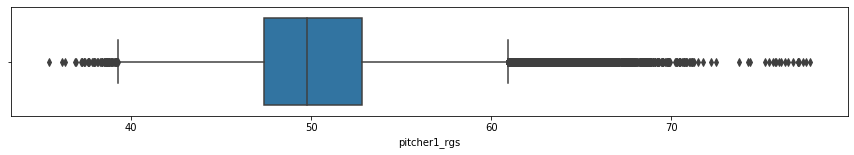

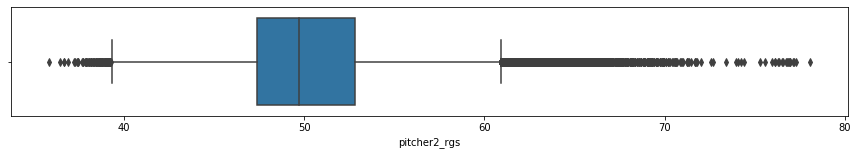

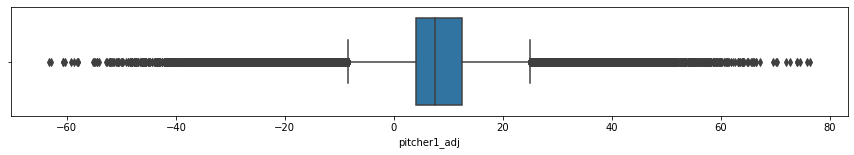

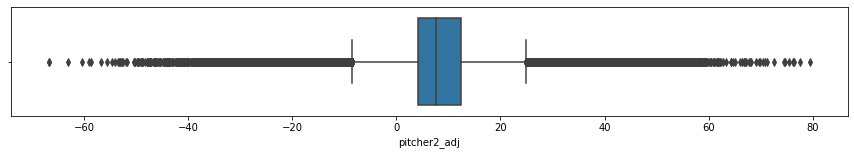

In [24]:
#iterate through the features, recording dataframes of potential outliers to a dictionary
outlier_dict = {}
for feature in (pitcher_features):
    outlier_dict[feature] = find_outliers(feature, mlb)
    plt.figure(figsize = (15,2))
    sns.boxplot(x = mlb[feature])    

/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


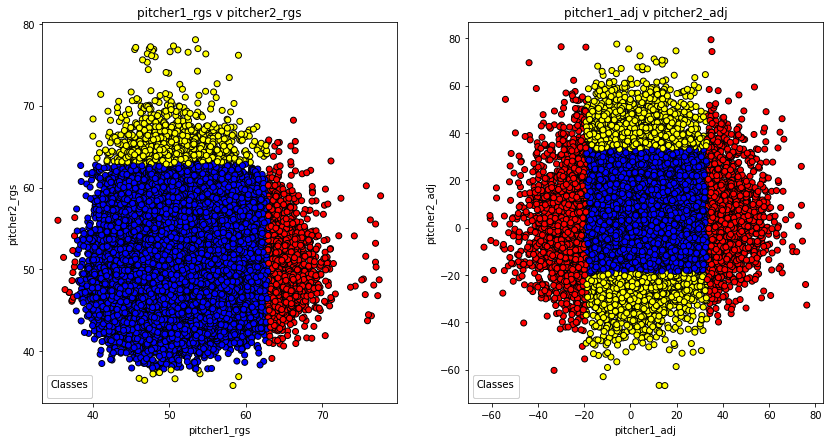

In [25]:
#create dataframes of feature columns w/ corresponding potential outliers
pitcher_ratings = pd.concat([outlier_dict['pitcher1_rgs'], outlier_dict['pitcher2_rgs']], axis = 1)
pitcher_adj = pd.concat([outlier_dict['pitcher1_adj'], outlier_dict['pitcher2_adj']], axis = 1)
pitcher_ratings.columns = ['pitcher1_rgs', 'outliers_x', 'pitcher2_rgs', 'outliers_y']
pitcher_adj.columns = ['pitcher1_adj', 'outliers_x', 'pitcher2_adj', 'outliers_y']
pitcher_frames = [pitcher_ratings, pitcher_adj]

#generate bivariate outlier plots
fig, ax = plt.subplots(1, 2, figsize = (14,7), sharex = False, sharey = False)
for i, df in enumerate(pitcher_frames):
    col_names = list(df.columns)
    color_scheme = np.where(df[col_names[1]] == 1, 'red',
                           np.where(df[col_names[3]] == 1, 'yellow', 'blue'))
    scatter = ax[i].scatter(x = df[col_names[0]], y = df[col_names[2]], c = color_scheme,
                           edgecolors = 'black')
    legend1 = ax[i].legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    ax[i].add_artist(legend1)
    ax[i].set_title('{} v {}'.format(col_names[0], col_names[2]))
    ax[i].set_xlabel(col_names[0])
    ax[i].set_ylabel(col_names[2]);
    


The two pitcher_adjusted rating features, while they are clearly not normally distributed (well more than $.03\%$ of the data falls outside of three standard deviations), are not skewed and there are no major outliers impacting the summary statistics. The distribution is not centered at zero, but that can be corrected by the StandardScaler after imputing missing values, there is no need to remove/correct data here. 

The scatter plot of the pitcher_rating features is more troubling. The distribution is clearly skewed high: the vast majority of observations outside of the three standard deviations are to one side of the distribution. 

In [26]:
#determine percentage of observations outside three standard deviations
print(pitcher_ratings.outliers_x.value_counts())

#calculate mean with outliers included
pitcher1_mean_WO = pitcher_ratings['pitcher1_rgs'].mean()
#calculate mean without outliers
pitcher1_mean_NO = pitcher_ratings[pitcher_ratings.outliers_x == 0]['pitcher1_rgs'].mean()
print('The mean with potential outliers included is {}'.format(pitcher1_mean_WO))
print('The mean without potential outliers included is {}'.format(pitcher1_mean_NO))

0    198608
1      1501
Name: outliers_x, dtype: int64
The mean with potential outliers included is 50.34300281346096
The mean without potential outliers included is 50.224316563940725


The change to the column mean with or without the outliers is not significant, and after looking into the pitcher_rgs columns, it appears that the ratings are not erroneous, the statistic is just slightly skewed high: great pitchers are more likely to have a very high rating than bad pitchers are to have a very low rating. As always, I would like to remove as little data as possible so I will not remove observations here, thus I will scale this column as well but will leave all observations in.

In [27]:
#function to impute pitcher means
#args: column of home pitcher names, column of home pitcher ratings, column of away pitchers, column of away pitcher
#ratings, dataframe
#returns: list of pitchers where mean was unavailable
def impute_pitcher_means(name_col, rating_col, name_col_2, rating_col_2, df):
    no_data_available = []
    missing_values = df[df[rating_col].isnull()][name_col].value_counts()
    for k in range(len(missing_values)):
        pitcher = missing_values.index[k]
        try:
            pitcher_avg = df[(df[name_col] == pitcher) & (df[rating_col].notnull())][rating_col].mean()
        except Exception:
            no_data_available.append(pitcher)
            continue
        if (0 <= pitcher_avg <= 100) == False:
            pitcher_avg = df[(df[name_col_2] == pitcher) & (df[rating_col_2].notnull())][rating_col_2].mean()
            if (0 <= pitcher_avg <= 100) == False:
                pitcher_avg = df[rating_col].mean()
        pitcher_indices = df[(df[name_col] == pitcher) & (df[rating_col].isnull())].index
        for n in pitcher_indices:
            df.at[n, rating_col] = pitcher_avg
    missing_both = df[(df[name_col].isnull()) & (df[rating_col].isnull())].index
    pitcher_avg = df[rating_col].mean()
    for m in missing_both:
        df.at[m, rating_col] = pitcher_avg
    return(no_data_available)

In [28]:
#impute missing pitcher1 ratings
missing_pitcher1_rgs = impute_pitcher_means('pitcher1', 'pitcher1_rgs', 'pitcher2', 'pitcher2_rgs', mlb)
missing_pitcher1_adj = impute_pitcher_means('pitcher1', 'pitcher1_adj', 'pitcher2', 'pitcher2_adj', mlb)

In [29]:
#confirm all missing values imputed
pitcher1_rgs_missing = mlb[(mlb.pitcher1_rgs.isnull())]['pitcher1'].value_counts()
pitcher1_adj_missing = mlb[(mlb.pitcher1_adj.isnull())]['pitcher1'].value_counts()
print(len(pitcher1_rgs_missing), len(pitcher1_adj_missing))

0 0


In [30]:
#impute missing pitcher2 ratings
missing_pitcher2_rgs = impute_pitcher_means('pitcher2', 'pitcher2_rgs', 'pitcher1', 'pitcher1_rgs', mlb)
missing_pitcher2_adj = impute_pitcher_means('pitcher2', 'pitcher2_adj', 'pitcher1', 'pitcher1_adj', mlb)

In [31]:
#confirm all missing values imputed
pitcher2_rgs_missing = mlb[(mlb.pitcher2_rgs.isnull())]['pitcher2'].value_counts()
pitcher2_adj_missing = mlb[(mlb.pitcher2_adj.isnull())]['pitcher2'].value_counts()
print(len(pitcher2_rgs_missing), len(pitcher2_adj_missing))

0 0


The scatter plots above make it clear that pitcher1_rg is not correlated with pitcher2_rg and pitcher1_adj is not correlated with pitcher2_adj, but in interest of thoroughness, I generated a heatmap to ensure that pitcher rating is not correlated with pitcher adjusted rating. 

In [32]:
#get correlations between pitcher featues
pitchers_corr = mlb[pitcher_features].corr()

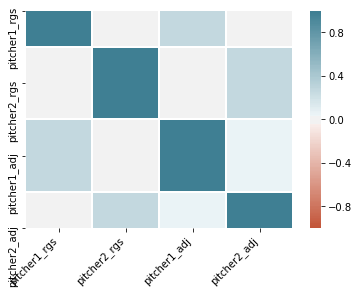

In [33]:
#plot heatmap 
ax = sns.heatmap(
    pitchers_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False, linewidths = 1
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [34]:
#with all pitcher ratings imputed, dropped pitcher columns 
mlb = mlb.drop(columns = ['pitcher1', 'pitcher2'])

A potential feature that could influence game out come could be the month of this season that the game is played. Teams with better records may be more likely to win games by large margin, whereas teams doing poorly that season may be more likely to lose by large margin. This feature can be easily created using the 'date' feature.

In [35]:
#create feature month from date
mlb['month'] = pd.DatetimeIndex(mlb.date).month

In [36]:
mlb.month.value_counts()

8     36306
7     35320
6     34215
5     33985
9     33887
4     22278
10     3955
3       152
11       11
Name: month, dtype: int64

The next areas of concern are the weather observations. There are missing observations for each element, and there's also the potential of faulty data collected from the NOAA. I will first look through for outliers, and then impute missing values. The logic I've decided to go with for missing values is simple: If a precipitation element ('PRCP', 'SNOW', 'SNWD') is missing, I will assume that the observation is missing because there was nothing to record, and thus I will impute a $0$. For missing temperature observations ('TMAX', 'TMIN'), I will calculate the mean for that location for that month and impute that value, as temperature is hugely variable from location to location and thus using global mean would likely do more harm than good.

In [37]:
#list of weather features
weather_features = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD']
#summary statistics of weather features
mlb[weather_features].describe()

,TMAX,TMIN,PRCP,SNOW,SNWD
count,199753.000000,199726.000000,199730.000000,175325.000000,168837.000000
mean,255.041496,149.320028,20.301257,0.030503,0.114708
std,61.435806,58.594068,67.767671,1.713452,6.224821
min,-22.000000,-156.000000,0.000000,0.000000,0.000000
25%,217.000000,111.000000,0.000000,0.000000,0.000000
50%,261.000000,156.000000,0.000000,0.000000,0.000000
75%,300.000000,194.000000,3.000000,0.000000,0.000000
max,478.000000,367.000000,2464.000000,320.000000,1041.000000


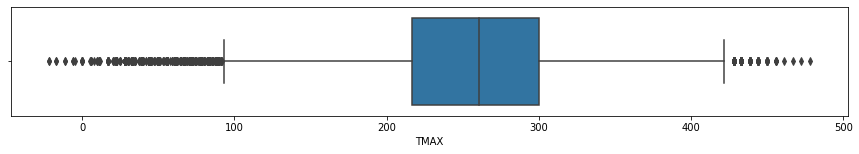

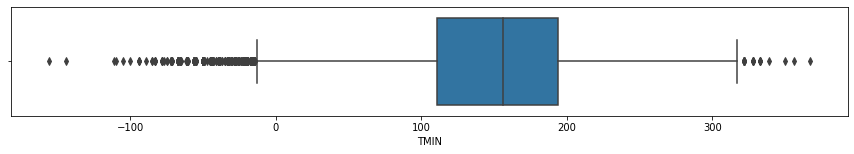

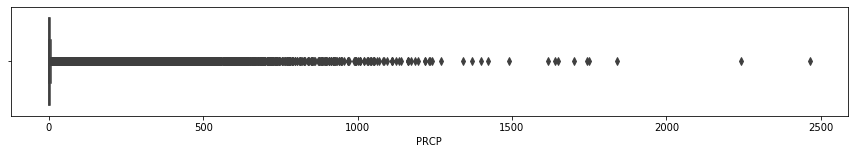

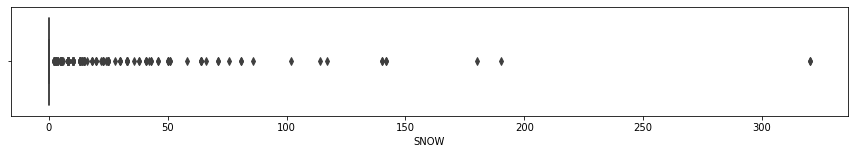

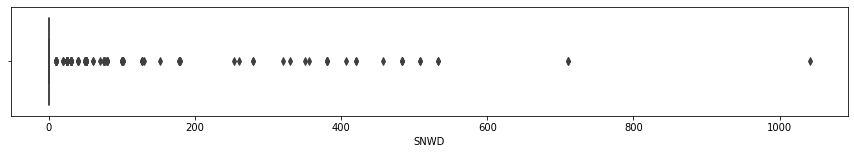

In [38]:
outlier_dict = {}
for feature in (weather_features):
    outlier_dict[feature] = find_outliers(feature, mlb)
    plt.figure(figsize = (15,2))
    sns.boxplot(x = mlb[feature])

Right off the bat, there are appear to be some outlier issues with the precipitation element observations. I will plot these elements against each other to determine the best course of action. 

In [39]:
outlier_dict_keys = list(outlier_dict.keys())
outlier_list = [outlier_dict[key] for key in outlier_dict_keys]
outlier_frame = pd.concat(outlier_list, axis = 1)
outlier_frame.columns = ['TMAX', 'outlier_max', 'TMIN', 'outlier_min', 'PRCP', 'outlier_p', 'SNOW', 'outlier_s',
                         'SNWD', 'outlier_sw']

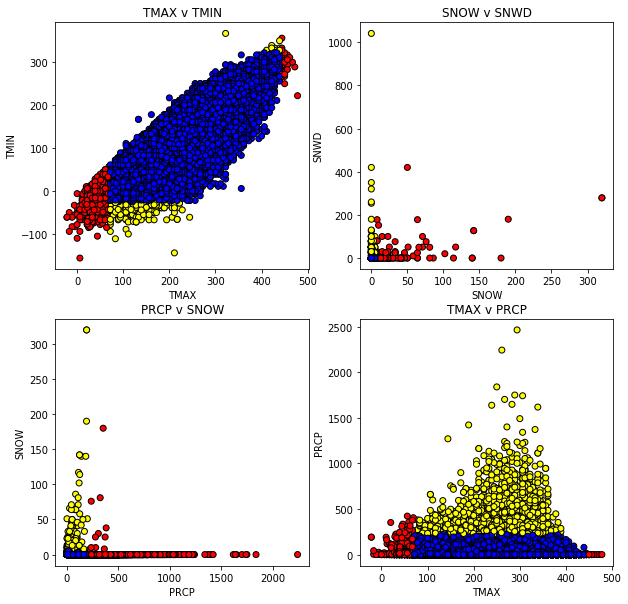

In [40]:
#generate bivariate outlier plots
fig, ax = plt.subplots(2, 2, figsize = (10, 10), sharex = False, sharey = False)
#TMAX v TMIN
temp_scheme = np.where(outlier_frame.outlier_max == 1, 'red',
                      np.where(outlier_frame.outlier_min == 1, 'yellow', 'blue'))
scatter_temp = ax[0,0].scatter(x = outlier_frame.TMAX, y = outlier_frame.TMIN, c = temp_scheme,
                              edgecolors = 'black')
ax[0,0].set_title('TMAX v TMIN')
ax[0,0].set_xlabel('TMAX')
ax[0,0].set_ylabel('TMIN')
#PRCP v SNOW
prcp_scheme = np.where(outlier_frame.outlier_p == 1, 'red',
                       np.where(outlier_frame.outlier_s == 1, 'yellow', 'blue'))
scatter_prcp = ax[1,0].scatter(x = outlier_frame.PRCP, y = outlier_frame.SNOW, c = prcp_scheme,
                              edgecolors = 'black')
ax[1,0].set_title('PRCP v SNOW')
ax[1,0].set_xlabel('PRCP')
ax[1,0].set_ylabel('SNOW')
#SNOW v SNWD
snow_scheme = np.where(outlier_frame.outlier_s == 1, 'red',
                      np.where(outlier_frame.outlier_sw == 1, 'yellow', 'blue'))
scatter_snow = ax[0,1].scatter(x = outlier_frame.SNOW, y = outlier_frame.SNWD, c = snow_scheme,
                              edgecolors = 'black')
ax[0,1].set_title('SNOW v SNWD')
ax[0,1].set_xlabel('SNOW')
ax[0,1].set_ylabel('SNWD')
#TMAX v PRCP
temp2_scheme = np.where(outlier_frame.outlier_max == 1, 'red',
                      np.where(outlier_frame.outlier_p == 1, 'yellow', 'blue'))
scatter_temp2 = ax[1,1].scatter(x = outlier_frame.TMAX, y = outlier_frame.PRCP, c = temp2_scheme,
                              edgecolors = 'black')
ax[1,1].set_title('TMAX v PRCP')
ax[1,1].set_xlabel('TMAX')
ax[1,1].set_ylabel('PRCP');


The temperature plots reveal a number of issues with the data. There is clearly a linear relationship between TMAX and TMIN (as could be expected, day and night temperatures would be related). There are clearly some large outliers in the precipitation elements to investigate. The first step will be to determine what's behind the precipitation outliers. If these outliers are from observations with fixed roofs/retractable roofs, then nothing needs to be done as these values are going to be adjusted later once mean temperatures have been calculated. As the null values for all precipitation elements will be replaced with zeros, it doesn't matter if the remain in the dataset for the time being as they will have no effect on mean temperature calculations. 

However, if these outliers are not from observations with a closed roof, then they likely need to be removed from the dataset as it's highly unlikely that games were played under such conditions. 

In [41]:
#drop TMIN column 
mlb = mlb.drop(columns = ['TMIN'])

In [42]:
#determine proportion of outliers for each element 
print(outlier_frame.outlier_p.value_counts())
print(outlier_frame.outlier_s.value_counts())
print(outlier_frame.outlier_sw.value_counts())

0    195663
1      4446
Name: outlier_p, dtype: int64
0    199964
1       145
Name: outlier_s, dtype: int64
0    199951
1       158
Name: outlier_sw, dtype: int64


In [43]:
#add retractable roof, fixed roof features
outlier_frame = pd.concat([outlier_frame, mlb.roof_closed, mlb.is_retractable], axis = 1)

#PRCP large outliers w/ roof open
prcp_problems = outlier_frame[(outlier_frame.PRCP > 500 ) & (outlier_frame.roof_closed == 0) & 
                             (outlier_frame.is_retractable == 0)]

#SNOW large outliers w/ roof closed
snow_problems = outlier_frame[(outlier_frame.outlier_s == 1) & (outlier_frame.roof_closed == 0) & 
                             (outlier_frame.is_retractable == 0)]

#SNWD large outliers w/ roof closed
snwd_problems = outlier_frame[(outlier_frame.outlier_sw == 1) & (outlier_frame.roof_closed == 0) & 
                             (outlier_frame.is_retractable == 0)]
print('PRCP: {}, SNOW: {}, SNWD: {}'.format(len(prcp_problems), len(snow_problems), len(snwd_problems)))

PRCP: 495, SNOW: 101, SNWD: 107


In [44]:
#fill missing snow and precipitation values with 0
mlb['PRCP'] = mlb['PRCP'].fillna(0)
mlb['SNOW'] = mlb['SNOW'].fillna(0)
mlb['SNWD'] = mlb['SNWD'].fillna(0)

In [45]:
#function to replace missing weather observation elements with monthly average for location
#args: element, dataframe
def impute_missing_temp(element, df):
    missing_indices = df[df[element].isnull()].index
    for index in missing_indices:
        month = df.iloc[index]['month']
        lat = df.iloc[index]['primary_latitude']
        lon = df.iloc[index]['primary_longitude']
        element_avg = df[(df['month'] == month) & (df['primary_latitude'] == lat) &\
                        (df['primary_longitude'] == lon) & (df[element].notnull())][element].mean()
        df.at[index, element] = element_avg    

In [46]:
#impute missing TMAX values
impute_missing_temp('TMAX', mlb)

In [47]:
#remove ',' from attendance/game and convert to integer
mlb['attendance/game'] = mlb['attendance/game'].str.replace(',', '')
mlb['attendance/game'] = mlb['attendance/game'].astype('int64')

In [48]:
#replace missing game attendance values with stadium average for that year, drop average column
missing_attendance_indices = mlb[mlb.attendance.isnull()].index
for index in missing_attendance_indices:
    mlb.at[index, 'attendance'] = mlb.iloc[index]['attendance/game']
mlb = mlb.drop(columns = ['attendance/game'])

In [49]:
mlb['attendance'].describe()

count    200109.000000
mean      18839.275070
std       14026.521924
min           0.000000
25%        6478.000000
50%       16089.000000
75%       29550.000000
max      104000.000000
Name: attendance, dtype: float64

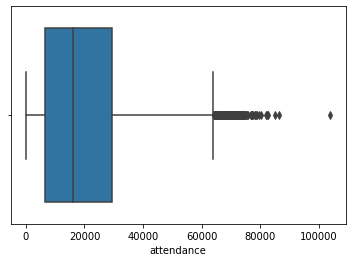

In [50]:
sns.boxplot(x = mlb['attendance']);

There is at least one large outlier for the attendance feature. In order to inform potential transformations, I have graphed attendance against season (and also against the target variable score differential) to examine potential relationships as well as the attendance outliers. 

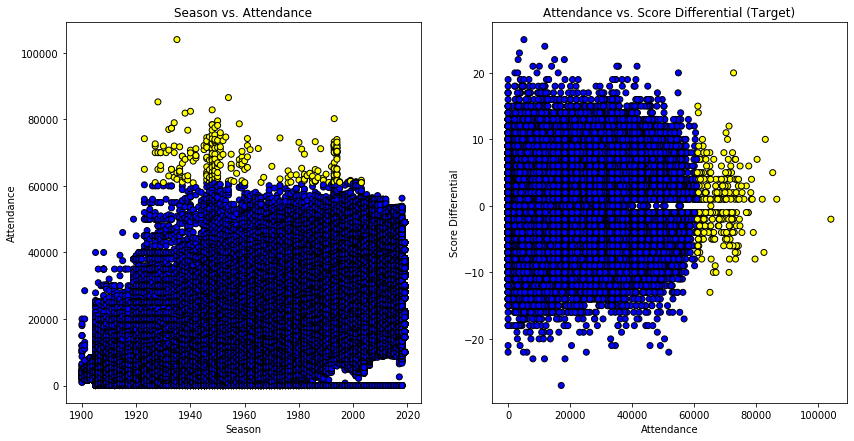

In [51]:
#generate possible outliers for attendance variable
attendance_outliers = find_outliers('attendance', mlb)

#create bivariate plots
fig, ax = plt.subplots(1, 2, figsize = (14,7), sharex = False, sharey = False)
attendance_scheme = np.where(attendance_outliers.is_outlier == 1, 'yellow', 'blue')

scatter_season = ax[0].scatter(x = mlb['season'], y = mlb['attendance'], c = attendance_scheme,
                               edgecolors = 'black')
#season v attendance plot
ax[0].set_title('Season vs. Attendance')
ax[0].set_xlabel('Season')
ax[0].set_ylabel('Attendance')

#attendance v target plot
scatter_target = ax[1].scatter(x = mlb['attendance'], y = (mlb['score1'] - mlb['score2']), c = attendance_scheme,
                              edgecolors = 'black')
ax[1].set_title('Attendance vs. Score Differential (Target)')
ax[1].set_xlabel('Attendance')
ax[1].set_ylabel('Score Differential');

In [52]:
#isolate index of large outlier
problem_index = mlb[['attendance']].idxmax()

In [53]:
#drop large outlier
mlb = mlb.drop(problem_index, axis = 0)

In [54]:
#reset index
mlb = mlb.reset_index().drop(columns = ['index'])

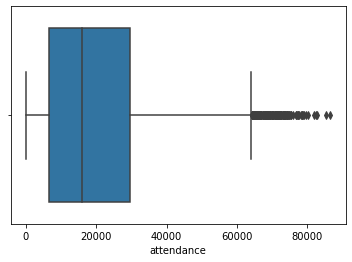

In [55]:
#confirm outlier removed
sns.boxplot(x = mlb['attendance']);

In [56]:
#view game_time feature
print(mlb.game_time.unique())
print(mlb.game_time.value_counts())

[nan 'D' 'N']
D    97662
N    82851
Name: game_time, dtype: int64


In [57]:
len(mlb[mlb.game_time.isnull()])

19595

In [58]:
#generate list of all years missing game time data
year_list = mlb[mlb.game_time.isnull()].season.value_counts().index

While there are a significant amount of game_time observations missing, it is simple to impute the values for all the seasons played before 1935: There were no stadium lights, and thus all games were day games. 

For the rest of the missing values, with the exception of the year 2019, they will be imputed with the following logic: Instead of imputing the most common value for each column (which doesn't take in to account that night games have increased as time has gone forward) I have calculated the percentage of day games/night games per year imputed the missing values according to that percentage.

In [59]:
#generate list of indices of games missing data before 1935
pre_1935_indices = mlb[(mlb.season < 1935) & (mlb.game_time.isnull())].index
#impute 'D' at each missing value, as there were no night games before 1935
for j in pre_1935_indices:
    mlb.at[j, 'game_time'] = 'D'

In [60]:
#list of years between 1935 and 2018 (data for 2019 was collected as whole season was missing)
post_1935_year_list = []
for year in year_list:
    if year >= 1935 and year < 2019:
        post_1935_year_list.append(year)

In [61]:
#function imputes missing gametimes using probabilities generated per given season. It did not make sense to 
#impute with most common value, as the distribution of day and night games has changed so vastly over the years.
def impute_missing_gametimes(year_list, df):
    for year in year_list:
        game_distribution = df[(df.season == year) & (df.game_time.notnull())].game_time.value_counts()
        missing_time_indices = df[(df.season == year) & (df.game_time.isnull())].index
        selection_dict = {game_distribution.index[0] : game_distribution[0],
                         game_distribution.index[1] : game_distribution[1]}
        game_times = list(selection_dict.keys())
        prob = selection_dict[game_times[0]] / (selection_dict[game_times[0]] + \
                                               selection_dict[game_times[1]])
        prob_list = [prob, 1-prob]
        for index in missing_time_indices:
            value = np.random.choice(game_times, p = prob_list)
            df.at[index, 'game_time'] = value
    print('All Values Imputed')
        
    

In [62]:
impute_missing_gametimes(post_1935_year_list, mlb)

All Values Imputed


The year 2019 was missing entirely, and as it is a manageable size, I wrote a scraper (see ____.py__) to collect the data from baseball-reference.com. Below, I read in the results and imputed the values to the main dataframe. 

In [63]:
#read in scraped data for 2019 game time
collected_2019_gametimes = pd.read_csv('data/br_2019_gametimes.csv', index_col = [0])
collected_2019_gametimes['game_date'] = pd.to_datetime(collected_2019_gametimes['game_date'])
collected_2019_gametimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2417 entries, 0 to 2416
Data columns (total 4 columns):
game_date          2417 non-null datetime64[ns]
game_time_br       2417 non-null object
is_doubleheader    2417 non-null int64
team_code          2417 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 94.4+ KB


In [64]:
#merge with main dataframe 
mlb = mlb.merge(collected_2019_gametimes, how = 'left', left_on = ['date', 'team1', 'is_double_header'],
               right_on = ['game_date', 'team_code', 'is_doubleheader'])

In [65]:
#fill in missing values in original dataframe from extended dataframe
indices = mlb[(mlb.season == 2019) & (mlb.game_time.isnull()) & (mlb.game_time_br.notnull())].index
for index in indices:
    val = mlb.iloc[index]['game_time_br']
    mlb.at[index, 'game_time'] = val

In [66]:
#drop merged columns
mlb = mlb.drop(columns = ['game_date', 'game_time_br', 'is_doubleheader', 'team_code'])

In [67]:
#fill in missing values with function from above
impute_missing_gametimes([2019], mlb)

All Values Imputed


In [68]:
#create dummy variables for gametime, dropping one of them to avoid collinearity
time_levels = pd.get_dummies(mlb.game_time)
time_levels.columns = ['is_daygame', 'is_nightgame']
mlb = pd.concat([mlb, time_levels], axis = 1).drop(columns = ['game_time', 'is_nightgame'])

In [69]:
#create dummy variables by month of season
month_levels = pd.get_dummies(mlb.month)
month_levels.columns = ['is_march', 'is_april', 'is_may', 'is_june', 'is_july', 'is_august', 'is_september',
                        'is_october','is_november']
mlb = pd.concat([mlb, month_levels], axis = 1).drop(columns = ['month'])

With no more missing values in the weather element columns, I collected the guidelines for when retractable roofs were closed (they differ by stadium) and wrote a function to change the weather values for when each stadium would be closed.

In [70]:
#tailor specifications for closing roof (based on team guidelines researched)
#confirmed using total percentage of games closed
TOR_guidelines = {'max_temp' : None,
                 'min_temp' : 100.0,
                 'is_daygame' : None}
HOU_guidelines = {'max_temp' : 310.0,
                 'min_temp' : 180.0,
                 'is_daygame' : None}
SEA_guidelines = {'max_temp' : None,
                 'min_temp' : None,
                 'is_daygame' : None}
MIL_guidelines = {'max_temp' : None,
                 'min_temp' : 150.0,
                 'is_daygame' : None}
FLA_guidelines = {'max_temp' : 310.0,
                 'min_temp' : 180.0,
                 'is_daygame' : None}
ARI_guidelines = {'max_temp' : 377.0,
                 'min_temp' : 180.0,
                 'is_daygame' : 0}

guideline_dict = {'TOR' : TOR_guidelines,
                 'HOU' : HOU_guidelines,
                 'SEA': SEA_guidelines,
                 'MIL' : MIL_guidelines,
                 'FLA' : FLA_guidelines,
                 'ARI' : ARI_guidelines}

In [71]:
#function to determine when retractable rooved stadiums are closed
#inputs are the guideline dictionary for each stadium (determined by research) and the dataframe to perform this on
def retractable_roof_closed(guide_dict, df):
    for team in guide_dict.keys():
        retractable_games = df[(df.team1 == team) & (df.is_retractable == 1)]
        if guide_dict[team]['max_temp'] == None and guide_dict[team]['min_temp'] != None:
            closed_roof_games = retractable_games[(retractable_games.TMAX <= guide_dict[team]['min_temp']) |
                                                  (retractable_games.PRCP != 0) | 
                                                  (retractable_games.SNOW != 0)].index
        elif guide_dict[team]['max_temp'] != None and guide_dict[team]['min_temp'] != None:
            closed_roof_games = retractable_games[(retractable_games.TMAX <= guide_dict[team]['min_temp']) |
                                                 (retractable_games.TMAX >= guide_dict[team]['max_temp']) |
                                                 (retractable_games.PRCP != 0) | 
                                                 (retractable_games.SNOW != 0)].index
        elif guide_dict[team]['is_daygame'] != None:
            closed_roof_games = retractable_games[(retractable_games.TMAX <= guide_dict[team]['min_temp']) |
                                                 (retractable_games.TMAX >= guide_dict[team]['max_temp']) | 
                                                 (retractable_games.is_daygame == 1) |
                                                 (retractable_games.PRCP != 0) | 
                                                 (retractable_games.SNOW != 0)].index
        else:
            closed_roof_games = retractable_games[(retractable_games.PRCP != 0) |
                                                 (retractable_games.SNOW != 0)].index
        for index in closed_roof_games:
            df.at[index, 'roof_closed'] = 1
            
            
        
        
        

In [72]:
#impute roof_closed as 1 for games meeting specifications set out by individual teams
retractable_roof_closed(guideline_dict, mlb)

In [73]:
#impute closed roof values for tempreature and precipitation
fixed_roof_indices = mlb[mlb.roof_closed == 1].index
temp_avg = mlb.TMAX.mean()
for index in fixed_roof_indices:
    mlb.at[index, 'TMAX'] = temp_avg
    mlb.at[index, 'PRCP'] = 0
    mlb.at[index, 'SNOW'] = 0
    mlb.at[index, 'SNWD'] = 0

In [74]:
mlb.to_csv('/Users/atticussoane/Retrosheet/full_elo.csv.gz', index = False, compression = 'gzip')

# STOP IDIOT

In [74]:
#drop unnecessary columns
mlb = mlb.drop(columns = ['team1', 'team2', 'is_retractable'])

In [77]:
#drop unnecessary columns, change datatypes 
mlb = mlb.drop(columns = ['date'])
mlb['attendance'] = mlb['attendance'].astype('int64')
mlb['neutral'] = mlb['neutral'].astype('uint8')

In [78]:
#read in elevation, add to dataframe
elevations = pd.read_csv('data/coordinates_elevation_final.csv', index_col = [0])
elevations = elevations[['latitude', 'longitude', 'elevation_m']]
elevations.columns = ['primary_latitude', 'primary_longitude', 'elevation']

In [79]:
mlb = mlb.merge(elevations, how = 'left', left_on = ['primary_latitude', 'primary_longitude'],
               right_on = ['primary_latitude', 'primary_longitude'])

In [80]:
mlb = mlb.drop(columns = ['primary_latitude', 'primary_longitude'])

In [81]:
mlb['elevation'] = mlb['elevation'].fillna(mlb['elevation'].mean())

In [82]:
dead_ball_indices = mlb[mlb.season.between(1900, 1919)].index
live_ball_indices = mlb[mlb.season.between(1920, 1941)].index
integration_indices = mlb[mlb.season.between(1942, 1960)].index
expansion_indices = mlb[mlb.season.between(1961, 1976)].index
FA_indices = mlb[mlb.season.between(1977, 1993)].index
steroid_indices = mlb[mlb.season.between(1994, 2005)].index
modern_indices = mlb[mlb.season.between(2006, 2019)].index

In [83]:
eras = ['is_deadball', 'is_liveball', 'is_integration', 'is_expansion', 'is_FA', 'is_steroid', 'is_modern']
indices = [dead_ball_indices, live_ball_indices, integration_indices, expansion_indices, FA_indices, 
          steroid_indices, modern_indices]
if len(eras) == len(indices):
    n = len(eras)
    for i in range(n):
        era = eras[i]
        index = indices[i]
        for j in index:
            mlb.at[j, era] = 1

In [84]:
mlb[eras] = mlb[eras].fillna(0)

In [85]:
mlb = mlb.drop(columns = ['season'])

In [86]:
mlb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200108 entries, 0 to 200107
Data columns (total 62 columns):
neutral                       200108 non-null uint8
elo1_pre                      200108 non-null float64
elo2_pre                      200108 non-null float64
elo_prob1                     200108 non-null float64
elo_prob2                     200108 non-null float64
elo1_post                     200108 non-null float64
elo2_post                     200108 non-null float64
rating1_pre                   200108 non-null float64
rating2_pre                   200108 non-null float64
pitcher1_rgs                  200108 non-null float64
pitcher2_rgs                  200108 non-null float64
pitcher1_adj                  200108 non-null float64
pitcher2_adj                  200108 non-null float64
rating_prob1                  200108 non-null float64
rating_prob2                  200108 non-null float64
rating1_post                  200108 non-null float64
rating2_post               

In [87]:
mlb['score_differential'] = mlb['score1'] - mlb['score2']

In [88]:
mlb.to_csv('all_numeric.csv.gz', compression = 'gzip', index = False)

In [89]:
mlb = mlb.drop(columns = ['score1', 'score2'])

In [90]:
#generate dataframes of features and target variable
feature_frame = mlb.drop(columns = ['score_differential'])
target = mlb['score_differential']

In [91]:
target.describe()

count    200108.000000
mean          0.159024
std           4.245071
min         -27.000000
25%          -2.000000
50%           1.000000
75%           3.000000
max          25.000000
Name: score_differential, dtype: float64

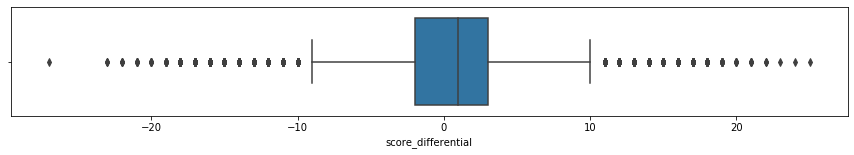

In [92]:
plt.figure(figsize = (15, 2))
sns.boxplot(x = target);

In [93]:
#generate dataframe of feature correlations
feature_corr = feature_frame.corr()

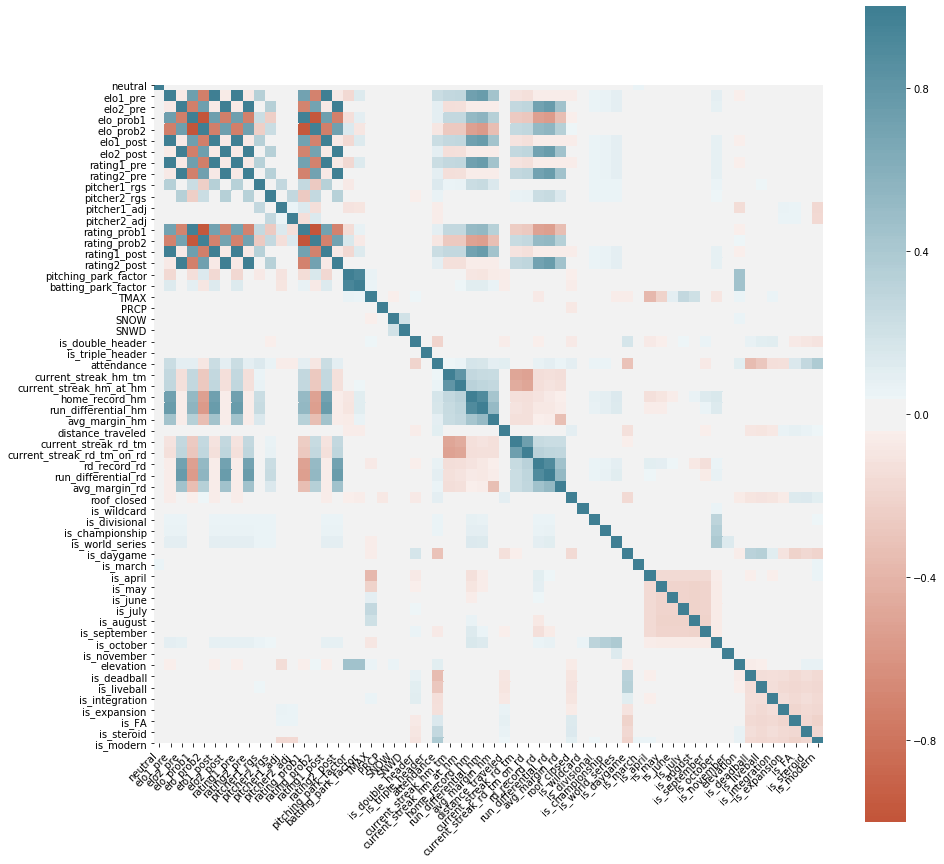

In [94]:
plt.figure(figsize = (15, 15))

ax = sns.heatmap(
    feature_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The majority of the problems seem to be within a certain subset of the features (the various features used to evaluate team ratings). I will isolate these features and work with them to gain a clearer picture.

In [95]:
#absolute values of correlations
mlb_corr_dfx = feature_corr.abs()

#keep only upper triangular portion of symmetric matrix to avoid redundancy
correlated_pairs = mlb_corr_dfx.where(np.triu(np.ones(mlb_corr_dfx.shape), k=1).astype(np.bool))

#generate multi-indexed series, sorted by highest correlation pairs
correlated_pairs = correlated_pairs.stack().sort_values(ascending = False)

#generated highly correlated feature pairs 
highly_correlated = correlated_pairs[correlated_pairs.values > 0.90]

In [96]:
highly_correlated

elo_prob1             elo_prob2              1.000000
rating_prob1          rating_prob2           1.000000
rating2_pre           rating2_post           0.997867
rating1_pre           rating1_post           0.997866
elo2_pre              elo2_post              0.997800
elo1_pre              elo1_post              0.997800
elo2_post             rating2_post           0.996622
elo1_post             rating1_post           0.996618
elo2_pre              rating2_pre            0.996589
elo1_pre              rating1_pre            0.996583
                      rating1_post           0.994485
elo2_pre              rating2_post           0.994477
elo2_post             rating2_pre            0.994419
elo1_post             rating1_pre            0.994400
elo_prob2             rating_prob2           0.974729
elo_prob1             rating_prob2           0.974729
elo_prob2             rating_prob1           0.974729
elo_prob1             rating_prob1           0.974729
pitching_park_factor  battin

In [97]:
potentially_correlated = correlated_pairs[correlated_pairs.values > 0.7]
potentially_correlated = potentially_correlated[potentially_correlated.values < 0.9]

In [98]:
potentially_correlated

rd_record_rd          run_differential_rd           0.890458
home_record_hm        run_differential_hm           0.890418
current_streak_hm_tm  current_streak_hm_at_hm       0.814526
elo2_pre              run_differential_rd           0.758110
rating2_pre           run_differential_rd           0.757018
elo2_post             run_differential_rd           0.756669
rating2_post          run_differential_rd           0.755700
elo1_pre              run_differential_hm           0.753731
elo1_post             run_differential_hm           0.752250
rating1_pre           run_differential_hm           0.752040
rating1_post          run_differential_hm           0.750687
elo1_pre              elo_prob1                     0.733835
                      elo_prob2                     0.733835
elo_prob2             elo1_post                     0.732476
elo_prob1             elo1_post                     0.732476
elo_prob2             rating1_pre                   0.731985
elo_prob1             ra

The top two pairs of correlated variables are quite simple: they are representative of $p$ and $1-p$ for two different probability metrics, and thus dropping one of them will be sufficient. The other pairs are less simple, but there is still a solution. The metrics with the suffix "post" represent the change in the metric rating the team after the game is played, which will then equal "_pre_" for the for the teams next game. As we are interested in predicting based on before the game is played, there is no reason to keep any ratings with the "post" suffix, and thus I will be dropping all of these. 

This does not fix the whole problem. The "elo" ratings are too highly correlated with the "rating" metric, and I will need to decide which one of these two to keep. I am inclined to keep the "rating" metric because it accounts for more factors than wins and losses, but after dropping the superfluous ratings I will look into which metric is more correlated with the target before determining which metric to drop. 

In [99]:
cols_to_drop = ['elo_prob2', 'elo1_post', 'elo2_post', 'rating_prob2',
                'rating1_post', 'rating2_post', 'batting_park_factor','elo1_pre', 'elo2_pre', 'elo_prob1',
               'neutral']
mlb = mlb.drop(columns = cols_to_drop)

In [100]:
mlb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200108 entries, 0 to 200107
Data columns (total 50 columns):
rating1_pre                   200108 non-null float64
rating2_pre                   200108 non-null float64
pitcher1_rgs                  200108 non-null float64
pitcher2_rgs                  200108 non-null float64
pitcher1_adj                  200108 non-null float64
pitcher2_adj                  200108 non-null float64
rating_prob1                  200108 non-null float64
pitching_park_factor          200108 non-null float64
TMAX                          200108 non-null float64
PRCP                          200108 non-null float64
SNOW                          200108 non-null float64
SNWD                          200108 non-null float64
is_double_header              200108 non-null int64
is_triple_header              200108 non-null int64
attendance                    200108 non-null int64
current_streak_hm_tm          200108 non-null int64
current_streak_hm_at_hm       200

In [101]:
team_statistics = mlb[mlb.columns[:26]].drop(columns = ['TMAX', 'PRCP', 'SNOW', 'SNWD', 'is_double_header', 
                                                       'is_triple_header', 'attendance'])

In [102]:
team_statistics.columns

Index(['rating1_pre', 'rating2_pre', 'pitcher1_rgs', 'pitcher2_rgs',
       'pitcher1_adj', 'pitcher2_adj', 'rating_prob1', 'pitching_park_factor',
       'current_streak_hm_tm', 'current_streak_hm_at_hm', 'home_record_hm',
       'run_differential_hm', 'avg_margin_hm', 'distance_traveled',
       'current_streak_rd_tm', 'current_streak_rd_tm_on_rd', 'rd_record_rd',
       'run_differential_rd', 'avg_margin_rd'],
      dtype='object')

In [103]:
team_statistics_corr = team_statistics.corr()
#absolute values of correlations
team_stats_dfx = team_statistics_corr.abs()

#keep only upper triangular portion of symmetric matrix to avoid redundancy
correlated_pairs = team_stats_dfx.where(np.triu(np.ones(team_stats_dfx.shape), k=1).astype(np.bool))

#generate multi-indexed series, sorted by highest correlation pairs
correlated_pairs = correlated_pairs.stack().sort_values(ascending = False)

#generated highly correlated feature pairs 
highly_correlated = correlated_pairs[correlated_pairs.values > 0.90]

In [104]:
correlation_issues = correlated_pairs[correlated_pairs.values > 0.70]
correlation_issues

rd_record_rd          run_differential_rd           0.890458
home_record_hm        run_differential_hm           0.890418
current_streak_hm_tm  current_streak_hm_at_hm       0.814526
rating2_pre           run_differential_rd           0.757018
rating1_pre           run_differential_hm           0.752040
current_streak_rd_tm  current_streak_rd_tm_on_rd    0.731640
rating1_pre           home_record_hm                0.719012
                      rating_prob1                  0.717529
rating2_pre           rd_record_rd                  0.716845
                      rating_prob1                  0.712560
dtype: float64

In [105]:
mlb = mlb.drop(columns = ['rd_record_rd', 'home_record_hm'])

In [106]:
team_statistics = team_statistics.drop(columns = ['rd_record_rd', 'home_record_hm'])

## Feature Selection

In [107]:
def get_feature_importances(df, target, n_iterations):
    pre_feature_selection = df.drop(columns = [target])
    col_names = pre_feature_selection.columns
    X = np.array(pre_feature_selection[:])
    y = np.array(df[target])
    feature_importances = np.zeros(len(col_names))
    for _ in range(n_iterations):
        lgr = lg.LGBMRegressor(n_trees = 1000, learning_rate = 0.05)
        lgr.fit(X, y)
        feature_importances += lgr.feature_importances_ / n_iterations
    feature_importance_df = pd.DataFrame({'feature' : col_names, 'importance' : feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending = False).reset_index(drop = True)
    return(feature_importance_df)
    

In [108]:
feature_importance = get_feature_importances(mlb, 'score_differential', 10)

In [109]:
feature_importance

,feature,importance
0,pitcher2_rgs,454.0
1,pitcher1_rgs,392.0
2,rating_prob1,277.0
3,pitcher1_adj,210.0
4,pitcher2_adj,187.0
5,run_differential_hm,160.0
6,attendance,154.0
7,rating1_pre,145.0
8,run_differential_rd,130.0
9,rating2_pre,126.0


In [110]:
#determine list of columns to standardize
normalize_cols = ['rating1_pre', 'rating2_pre', 'pitcher1_rgs', 'pitcher2_rgs', 'pitcher1_adj', 'pitcher2_adj',
                 'rating_prob1', 'pitching_park_factor', 'TMAX', 'attendance'] + list(new_features.columns) +\
['elevation', 'score_differential']

In [111]:
#remove columns that have already been dropped from the dataframe
normalize_cols.pop(normalize_cols.index('rd_record_rd'))

'rd_record_rd'

In [112]:
normalize_cols.pop(normalize_cols.index('home_record_hm'))

'home_record_hm'

In [113]:
normalize_cols

['rating1_pre',
 'rating2_pre',
 'pitcher1_rgs',
 'pitcher2_rgs',
 'pitcher1_adj',
 'pitcher2_adj',
 'rating_prob1',
 'pitching_park_factor',
 'TMAX',
 'attendance',
 'current_streak_hm_tm',
 'current_streak_hm_at_hm',
 'run_differential_hm',
 'avg_margin_hm',
 'distance_traveled',
 'current_streak_rd_tm',
 'current_streak_rd_tm_on_rd',
 'run_differential_rd',
 'avg_margin_rd',
 'elevation',
 'score_differential']

In [114]:
#create list of columns to feed to min max scaler
min_max_cols = ['PRCP', 'SNOW', 'SNWD']

In [115]:
#instantiate StandardScaler, MinMaxScaler
feature_scaler = StandardScaler()
precip_scaler = MinMaxScaler()

In [116]:
#fit scalers (not using fit transform so scalers can be saved)
feature_scaler.fit(mlb[normalize_cols])
precip_scaler.fit(mlb[min_max_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [117]:
#scale features
mlb[normalize_cols] = feature_scaler.transform(mlb[normalize_cols])
mlb[min_max_cols] = precip_scaler.transform(mlb[min_max_cols])

In [118]:
feature_importance_sc = get_feature_importances(mlb, 'score_differential', 10)

In [119]:
feature_importance_sc

,feature,importance
0,pitcher2_rgs,441.0
1,pitcher1_rgs,379.0
2,rating_prob1,308.0
3,pitcher1_adj,226.0
4,pitcher2_adj,169.0
5,run_differential_hm,163.0
6,rating1_pre,145.0
7,run_differential_rd,144.0
8,rating2_pre,130.0
9,TMAX,122.0


In [120]:
features_to_keep = feature_importance_sc[feature_importance_sc.importance >= 10]['feature']
selected_features = list(features_to_keep) + ['score_differential']

In [121]:
mlb = mlb[selected_features]

In [122]:
mlb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200108 entries, 0 to 200107
Data columns (total 27 columns):
pitcher2_rgs                  200108 non-null float64
pitcher1_rgs                  200108 non-null float64
rating_prob1                  200108 non-null float64
pitcher1_adj                  200108 non-null float64
pitcher2_adj                  200108 non-null float64
run_differential_hm           200108 non-null float64
rating1_pre                   200108 non-null float64
run_differential_rd           200108 non-null float64
rating2_pre                   200108 non-null float64
TMAX                          200108 non-null float64
attendance                    200108 non-null float64
pitching_park_factor          200108 non-null float64
elevation                     200108 non-null float64
distance_traveled             200108 non-null float64
current_streak_rd_tm_on_rd    200108 non-null float64
PRCP                          200108 non-null float64
current_streak_rd_tm     

In [123]:
mlb.to_csv('model_ready_.csv.gz', compression = 'gzip', index = False)